<div class="alert alert-success">
<b>Reviewer's comment V3</b>

Thanks for taking the time to improve the project! It is now accepted. Good luck on the next sprint!

</div>

**Review**

Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did a great job overall, but there are a couple of problems that need to be fixed before the project is accepted. Let me know if you have questions!

# Introduction

In the below training we will develop a model to predict the best-fit plan for user data based on their data, message, and call usage. We have a moderately-sized dataset of Megaline users and their respective plans. We do not know the ideal model or its ideal hyperparameters in advance, so we will iterate over many and identify the best-performing model based on accuracy. The aim is to develop a model above a threshold of 0.75 accuracy which, to be more specific, is a model that correctly predicts the plan for 75% of its validation set.

## Initialize Libraries, Look at Dataframe, Clean the Data

### Libraries

In [1]:
# Statistical libraries
import pandas as pd
from scipy import stats as st
import numpy as np
from sklearn.metrics import *
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

# Machine Learning libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Graphing libraries
from matplotlib import pyplot as plt

### Dataframe

In [2]:
# Read Dataframe
df = pd.read_csv('/datasets/Churn.csv')

# Quick look
df.info()
display(df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


Some of these fields are indexing or id features and should be dropped to avoid training the model on irrelevant data points. All fields have the correct data types.

We should look at the spread of the 'Tenure' field to determine what to do with its missing values, which represent a large portion of the data (10%):

<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was loaded and inspected

</div>

0.0     382
1.0     952
2.0     950
3.0     928
4.0     885
5.0     927
6.0     881
7.0     925
8.0     933
9.0     882
10.0    446
Name: Tenure, dtype: int64


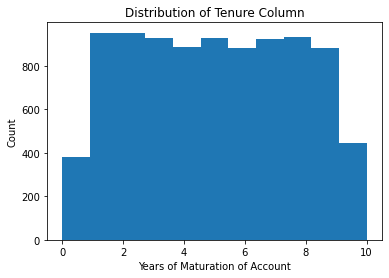

In [3]:
# What is the distribution of the 'Tenure' column?
print(df['Tenure'].value_counts().sort_index())

# Plot
df['Tenure'].plot.hist(bins=11)
plt.title('Distribution of Tenure Column')
plt.ylabel('Count')
plt.xlabel('Years of Maturation of Account')
plt.show()

The data is evenly distributed, not skewed outside of low values for 0 and 10 years of account maturation. We can replace missing values for 'Tenure' with mean values.

We may now clean the dataframe with the changes we have discussed:

### Cleaning the Dataframe

In [4]:
# We will make a new dataframe to avoid overwriting
# We are safe to drop 'RowNumber' and 'CustomerId' as they are indexing/id features. 
# We are safe to drop 'Surname' as it is an id feature and one-hot encoding would result in thousands of columns
data = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

# The 'Tenure' column has missing values that represent a large portion of the data (~10%). 
# It does not have a huge skew, so we will replace with mean value
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].mean())

# Create list of numeric tags to easily filter dataframe
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

# Review pre-processing fixes
data.info()
display(data.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


<div class="alert alert-warning">
<b>Reviewer's comment</b>

You can drop several columns by passing a list of column names:
    
```python
df.drop(['some_column', 'some_other_column', 'one_more_column'], axis=1)   
```

</div>

<div class="alert alert-info">
  That is way cleaner, making that adjustment
</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Great!

</div>

In [5]:
# Show imbalance of 'Exited' feature

print('')
print(data['Exited'].sum(), 'out of 10000, or {:.2f}% of the dataset, has target feature positive.'.format(100*data['Exited'].sum()/10000))


2037 out of 10000, or 20.37% of the dataset, has target feature positive.


With only about 1 in 5 entries being positively classified in the entire dataset, we are low on positive entries. Our focus is on identifying current customers who are at risk of churning -- we want to identify as many at-risk customers as we can. Without giving the positive entries the weight they need, we risk mis-training our model.

Below, we will first see how the Random Forest model performs without making such an adjustment, and then we will balance the data with upsampling and threshold tuning, and re-train the model.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Good job on data preprocessing! You dropped irrelevant columns, and reasonably dealt with missing values. Class balance was examined

</div>

## Train Model Without Balancing


### One-Hot Encode Categorical Features

In [6]:
# Encode categorical features into new dataframe
data_ohe = pd.get_dummies(data, drop_first=True)

<div class="alert alert-success">
<b>Reviewer's comment</b>

Categorical features were encoded

</div>

### Split the Source Data into Training and Validation Sets

In [7]:
# Separate dataframe into features and targets and randomize using train_test_split
features = data_ohe.drop(['Exited'], axis=1)
target = data_ohe['Exited']

# Split data to make train, validation, and test sets in ratio of 3:1:1, first with a 3:2 split then a 1:1 split in remaining
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, random_state=140)
features_test, features_valid, target_test, target_valid = train_test_split(features_valid, target_valid, test_size=0.5, random_state=140)

# Standardizing each feature's scaling is very important when features differ by any order of magnitude
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

/tmp/ipykernel_50/3534733234.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


<div class="alert alert-danger">
<s><b>Reviewer's comment</b>

Like in the last project, we need to split the data into three parts: train, validation and test.
    
- The train set is used to train the models.
- The validation set is used to tune hyperparameters, compare different balancing techniques and do model selection.
- The test set is used to evaluate the final model.
    
The test set is needed because as the validation is used to tune the model, the validation set score of the final model is inherenetly overly optimistic. To get an unbiased estimate of its generalization performance we need to evaluate it on new data which was not used to make any decisions about the model.
    
</div>

<div class="alert alert-info">
  Yes I was confused about this, because of course we need to evaluate the model on new data separate from tuning the model, but in the last project (Sprint 7) my project was approved without doing the test set, and in all the sprint assignments they only use train and validation. I've changed the above section to now use a ratio of 3:1:1, and I just made two calls to train_test_split. Is that standard protocol or is there a cleaner way?
</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Yeah, that's a standard way to do it.
    
> but in the last project (Sprint 7) my project was approved without doing the test set, and in all the sprint assignments they only use train and validation
    
Hmm, that's weird! Here's a nice short [reference](https://sebastianraschka.com/faq/docs/evaluate-a-model.html)

</div>

### Train Random Forest Model, Maximizing F1 Score

In [8]:
# Initialize null model, result (root mean squared error), and hyperparameters
best_rf_model = None
best_rf_result = 0
best_rf_est = 0
best_rf_depth = 0

# Try various hyperparameters over the Random Forest Classifier
# We loop over number of estimators in the set {30, 40, 50, ... 130} and max depth in the set {5, 6, 7, ... 12}
for est in range(30, 131, 10):
    for depth in range(5, 13):
        model = RandomForestClassifier(max_depth=depth, random_state=12345, n_estimators=est)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        if result > best_rf_result:
            best_rf_model = model
            best_rf_result = result
            best_rf_est = est
            best_rf_depth = depth

### Analyze Resulting Model on Test Set

In [9]:
# First pass AUC-ROC of best model on test set
probabilities_test = best_rf_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
print("AUC-ROC score for best-performing model :", roc_auc_score(target_test, probabilities_one_test))

# First pass F1 of best model on test set
print("F1 score for best-performing model :", f1_score(target_test, best_rf_model.predict(features_test)))

# Hyperparameters of best model
print('Hyperparameters for best-performing model :')
print('    Number of estimators :', best_rf_est)
print('    Max depth            :', best_rf_depth)

AUC-ROC score for best-performing model : 0.8574252100840338
F1 score for best-performing model : 0.5764705882352941
Hyperparameters for best-performing model :
    Number of estimators : 110
    Max depth            : 12


<div class="alert alert-danger">
<s><b>Reviewer's comment</b>

To calculate ROC-AUC you need to use 'probabilities' rather than binary predictions

</div>

<div class="alert alert-info">
  Whoops, that's an oversight. Corrected it here.
</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Great!

</div>

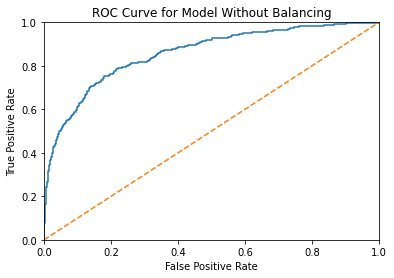

In [10]:
# Use best performing model for probability testing
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure()
plt.plot(fpr, tpr)

# Sanity check line (representing random guess model)
plt.plot([0, 1], [0, 1], linestyle='--')

# Cleaning
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Model Without Balancing')

plt.show()

The model performs moderately well, especially compared to random prediction. To avoid overfitting and heighten accuracy we only looked at using the Random Forest Classifier. It is not an excessively large dataset, so it is not taxing to use such an intensive model.

We need to balance the weights of the dataset target feature options -- currently, positive target feature entries account for only 20% of the dataset. We will upsample the positive target feature entries, set class_weight to 'balanced', and tune the threshold for positive classification in the resulting best model.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Great, you trained a model without taking the imbalance into account first and tuned its hyperparameters using the validation set

</div>

## Train Model With Balancing

<div class="alert alert-danger">
<s><b>Reviewer's comment</b>

There's no need to split the data again, you can use the subsets you made earlier :)

</div>

<div class="alert alert-info">
  Oh, of course. Can you tell I copy-pasted the first section before modifying it? Because I definitely copy-pasted. I deleted the excess sections on OHE the categorical features and on splitting!
</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Haha, yeah :)

</div>

We will first balance the classification weights with setting class_weight to 'balanced,' then train the model on that alone. Then, separately, we'll balance the classification weights by upsampling the dataset, with the goal of making the number of positive-target entries about equal to the negative-target entries. Finally, we'll compare metrics and the AUC-ROC plot for each resulting model.

### Train Random Forest Model, Maximizing F1 Score, Now Balancing Class Weight

In [11]:
# Initialize null model, result (root mean squared error), and hyperparameters
best_rf1_model = None
best_rf1_result = 0
best_rf1_est = 0
best_rf1_depth = 0

# Try various hyperparameters over the Random Forest Classifier
# We loop over number of estimators in the set {30, 40, 50, ... 130} and max depth in the set {5, 6, 7, ... 12}
# This time, we add class_weight parameter as 'balanced' to balance weights of the two target classes
for est in range(30, 131, 10):
    for depth in range(5, 13):
        model = RandomForestClassifier(max_depth=depth, random_state=12345, n_estimators=est, class_weight='balanced')
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        if result > best_rf1_result:
            best_rf1_model = model
            best_rf1_result = result
            best_rf1_est = est
            best_rf1_depth = depth

### Train Random Forest Model, Maximizing F1 Score, Now Upsampling Positive-Target Samples

In [12]:
# Function definition from material on upsampling
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled

# Upsample the training set only so as not to skew validation data. 
# Repeat value of 5 taken from ratio of positive to negative classification in base dataset (1:5)
features_upsampled, target_upsampled = upsample(
    features_train, target_train, 5
)

<div class="alert alert-success">
<b>Reviewer's comment</b>

Upsampling was correctly applied only to the train set, the repeat value makes sense

</div>

In [13]:
# Initialize null model, result (root mean squared error), and hyperparameters
best_rf2_model = None
best_rf2_result = 0
best_rf2_est = 0
best_rf2_depth = 0

# Try various hyperparameters over the Random Forest Classifier
# We loop over number of estimators in the set {30, 40, 50, ... 130} and max depth in the set {5, 6, 7, ... 12}
# This time, we add class_weight parameter as 'balanced' to balance weights of the two target classes
for est in range(30, 131, 10):
    for depth in range(5, 13):
        model = RandomForestClassifier(max_depth=depth, random_state=12345, n_estimators=est)
        model.fit(features_upsampled, target_upsampled)
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        if result > best_rf2_result:
            best_rf2_model = model
            best_rf2_result = result
            best_rf2_est = est
            best_rf2_depth = depth

### Adjust Classification Metrics -- Threshold Tuning for Each of the Above Models

In [14]:
# Initialize null threshold, f1_result, calculate positive classification probabilities for each instance in validation set
best_rf1_threshold = 0
best_rf1_result = 0
best_rf2_threshold = 0
best_rf2_result = 0
probabilities_rf1_valid = best_rf1_model.predict_proba(features_valid)
probabilities_rf1_one_valid = probabilities_rf1_valid[:, 1]
probabilities_rf2_valid = best_rf2_model.predict_proba(features_valid)
probabilities_rf2_one_valid = probabilities_rf2_valid[:, 1]

# Main loop for both rf models
for threshold in np.arange(0, 0.6, 0.02):
    predicted_rf1_valid = probabilities_rf1_one_valid > threshold
    predicted_rf2_valid = probabilities_rf2_one_valid > threshold
    rf1_result = f1_score(target_valid, predicted_rf1_valid)
    rf2_result = f1_score(target_valid, predicted_rf2_valid)
    if rf1_result > best_rf1_result:
        best_rf1_threshold = threshold
        best_rf1_result = result
    if rf2_result > best_rf2_result:
        best_rf2_threshold = threshold
        best_rf2_result = result
        
# Display results of tuning
print('')
print("Ideal threshold for maximizing F1 score in model setting equal_weights to 'balanced' :", best_rf1_threshold)
print('')
print("Ideal threshold for maximizing F1 score in model with upsampling :", best_rf2_threshold)


Ideal threshold for maximizing F1 score in model setting equal_weights to 'balanced' : 0.56

Ideal threshold for maximizing F1 score in model with upsampling : 0.56


<div class="alert alert-success">
<b>Reviewer's comment</b>

Good idea to tune the threshold!

</div>

### Analyze Resulting Upsample-Trained Model on Test Set

In [15]:
# Data target probabilities again for each best RF model, but this time using test set
probabilities_rf1_test = best_rf1_model.predict_proba(features_test)
probabilities_rf1_one_test = probabilities_rf1_test[:, 1]
probabilities_rf2_test = best_rf2_model.predict_proba(features_test)
probabilities_rf2_one_test = probabilities_rf2_test[:, 1]

# Print AUC-ROC and F1 of best RF models, using test set
print("AUC-ROC score for best-performing model setting equal_weights to 'balanced' :", roc_auc_score(target_test, probabilities_rf1_one_test))
print("F1 score for best-performing model setting equal_weights to 'balanced'      :", f1_score(target_test, best_rf1_model.predict(features_test)))
print('')
print("AUC-ROC score for best-performing model with upsampling                     :", roc_auc_score(target_test, probabilities_rf2_one_test))
print("F1 score for best-performing model with upsampling                          :", f1_score(target_test, best_rf2_model.predict(features_test)))
print('')


AUC-ROC score for best-performing model setting equal_weights to 'balanced' : 0.8631977591036415
F1 score for best-performing model setting equal_weights to 'balanced'      : 0.6294536817102138

AUC-ROC score for best-performing model with upsampling                     : 0.8552246498599438
F1 score for best-performing model with upsampling                          : 0.6276243093922652



<div class="alert alert-danger">
<s><b>Reviewer's comment</b>

Same problem with ROC-AUC as earlier

</div>

<div class="alert alert-info">
  Made same adjustment as above
</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Ok!

</div>

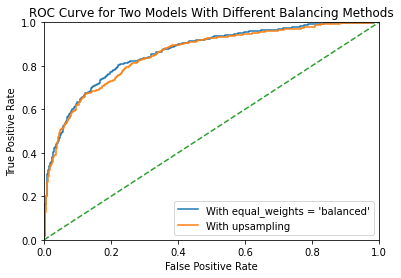

In [16]:
# Use best performing model for probability testing
# Plot ROC curve
fpr1, tpr1, thresholds = roc_curve(target_test, probabilities_rf1_one_test)
fpr2, tpr2, thresholds = roc_curve(target_test, probabilities_rf2_one_test)
plt.figure()
plt.plot(fpr1, tpr1)
plt.plot(fpr2, tpr2)

# Sanity check line (representing random guess model)
plt.plot([0, 1], [0, 1], linestyle='--')

# Cleaning
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Two Models With Different Balancing Methods')
plt.legend(["equal_weights = 'balanced'", "Upsampling"])

plt.show()

The two steps we took to enable our model to better classify its predictions -- upsampling and setting the class_weight to 'balanced' -- have independently increased the F1 value from 0.58 to 0.63. 

The threshold was a bit higher than expected for optimal F1 performance, coming in at 0.56. Having a higher threshold for positive classification lowers the false positive rate. In this instance, when presented with this model, the bank may opt to intentionally lower this threshold to improve recall. This is because they may be more concerned with capturing as many true positive clients as possible. There is, arguably, less risk in casting their net a little wider. On the other hand, the bank may raise the threshold to focus its efforts on sure-fire clients who are very likely to churn.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Yep, you are right, finding new customers is probably more expensive than keeping old customers

</div>

<div class="alert alert-danger">
<b>Reviewer's comment</b>

Two things:
    
1. In this project you're supposed to try at least two different balancing techniques and compare the results. You can try e.g. downsampling or class weights.
    
2. Don't forget to evaluate the final model on the test set after you select the best model/balancing technique etc.

</div>

<div class="alert alert-info">
  I passed the class_weight='balanced' parameter to the RandomForestClassifier function call for the second balancing technique. I realize now that tuning the threshold is more of a data exploration rather than a balancing technique.
    
  I changed all auc_roc and f1 scoring to use the test set rather than the validation set. If other evaluation metrics like R2 and MAE are expected here, I can add those.
</div>

<div class="alert alert-danger">
<s><b>Reviewer's comment V2</b>

Awesome! You're now applying both upsampling and class weights at the same time though. Could you try applying them separately for comparison's sake?
    
> If other evaluation metrics like R2 and MAE are expected here, I can add those.
    
Nope, in fact those are regression metrics and wouldn't be very useful for evaluating of a binary classification model :)

</div>

<div class="alert alert-info">
  Ah, to compare how each affect best f1 score, of course. I've done so above and rearranged some things in section 3 in general. Thanks for the notes.
</div>

<div class="alert alert-success">
<b>Reviewer's comment V3</b>

You're welcome :)

</div>

# Conclusion

In the above training we pre-processed a dataset for banking customers. We found we were able to develop a moderately-performing Random Forest model to predict likelihood of churning. Its performance was improved, though, once we upsampled the data for users who historically did churn, and when we set class_weight to 'balanced.' We also tuned the threshold for classifying a user as likely to churn, finding the ideal threshold for classification might be a bit higher than expected. The bank will take this model and be able to make decisions on which currently-active customers to market to, reducing their likelihood of churning. It may increase or lower the threshold of targeting depending on its business needs.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Great!

</div>